## The Metropolis-Hastings Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.animation import FuncAnimation
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Let's study this good looking fancy distribution where its PDF is defined such as :     
###<center>$f(x) = \frac{0.5}{2\pi\sigma_1^2} \exp\left(-\frac{1}{2}\sum_{i=1}^{n}\left(\frac{x_i - 1.5}{\sigma_1}\right)^2\right) + \frac{0.5}{2\pi\sigma_2^2} \exp\left(-\frac{1}{2}\sum_{i=1}^{n}\left(\frac{x_i + 1.0}{\sigma_2}\right)^2\right)$
###Supposing $X$ is a Random Vector, ie., $X = (X_1, X_2,....., X_D)$. So the target distribution is the following :    

###<center>$X \sim \frac{0.5}{\sqrt{2π}⋅{\sigma_1}} ⋅\mathcal{N}(1.5, \sigma_1^2) + \frac{0.5}{\sqrt{2π}⋅{\sigma_2}} ⋅\mathcal{N}(-1, \sigma_2^2)$

###From now on, we will consider $n$ to be equal to 2, ie., the corresponding random vector is indeed $X=(X_1, X_2)$, hence the pdf is :     
###<center>$f(x_1,x_2) = \frac{0.5}{2\pi\sigma_1^2} \exp\left(-\frac{1}{2}\left(\frac{x_1 - 1.5}{\sigma_1}\right)^2-\frac{1}{2}\left(\frac{x_2 - 1.5}{\sigma_1}\right)^2 \right)  + \frac{0.5}{2\pi\sigma_2^2} \exp\left(-\frac{1}{2}\left(\frac{x_1 + 1.0}{\sigma_2}\right)^2-\frac{1}{2}\left(\frac{x_2 + 1.0}{\sigma_2}\right)^2\right)$

In [3]:
def fancy_distribution(x):
    '''Bimodal pdf'''
    sigma1 = 1.0
    sigma2 = 0.5
    pdf = 0.5/(2*np.pi*sigma1**2)*np.exp(-0.5*((x-1.5)**2).sum()/sigma1**2)  +  0.5/(2*np.pi*sigma2**2)*np.exp(-0.5*((x+1.0)**2).sum()/sigma2**2)
    return pdf

##Visualization of the fancy distribution for two variables $x_1$ &  $x_2$

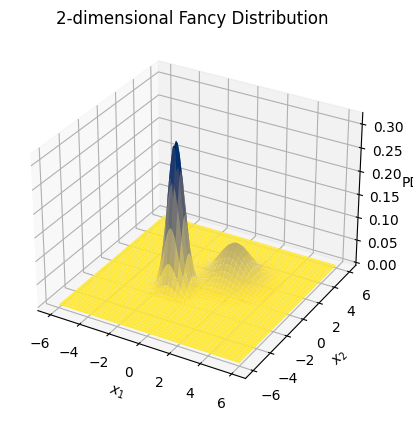

In [4]:
x1_values = np.linspace(-6, 6, 100)
x2_values = np.linspace(-6, 6, 100)
x1_grid, x2_grid = np.meshgrid(x1_values, x2_values)          # meshgrid for x1 and x2


pdf_values = np.zeros_like(x1_grid)                           #  PDF values for each point in the meshgrid

for i in range(len(x1_values)):
    for j in range(len(x2_values)):
        pdf_values[i, j] = fancy_distribution(np.array([x1_grid[i, j], x2_grid[i, j]]))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')                    # Create a 3D surface plot

ax.plot_surface(x1_grid, x2_grid, pdf_values, cmap='cividis_r')


ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')                                            #labels and titles
ax.set_zlabel('PDF')
ax.set_title('2-dimensional Fancy Distribution ')

# Show the plot
plt.show()

##Visualization of the fancy distribution for only one variable, so as to get an intuition of the probability density function

In [5]:
values = np.arange(-5, 5, 0.001)
difference_values = np.diff(values)

unidimensional_fancy_distribution = np.array([np.sum(fancy_distribution(np.array([i, values])) * difference_values[0]) for i in values])

fig = px.line(x=values, y=unidimensional_fancy_distribution, labels={'x': '$x$', 'y': 'Probability Density Function'},
              title='Unidimensional Fancy Distribution')

fig.show()

<ipython-input-5-bf43f33bd427>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unidimensional_fancy_distribution = np.array([np.sum(fancy_distribution(np.array([i, values])) * difference_values[0]) for i in values])




## Generate some samples from this fancy distribution

### Define a Markov chain over possible x values, so that the stationary distribution of the Markov Chain is the $P(X)$. Use Markov chain to generate a sequence of $x$ values, denoted $(x_{0},x_{1},x...)$, so that as $n \to \infty$, we can guarantee that $x_{n} \sim P(x)$

# A quick explanatory overview of The Metropolis-Hastings Algorithm



### We know the current state $x_{n}$, and we want to generate $x_{n+1}$. This is a 2 step process.
### 1st step is to generate a candidate $x^{*}$, which is generated from a proposal distribution $Q(X^{*} | x_{n})$ which depends on the current state of the Markov chain $x_{n}$. We need a distribution that is centered on $x_n$, so can use something like:

### $X^{*} | X_{n} \sim \mathcal{N}(x_{n}, \sigma^{2})$ where we punch in our own $\sigma$.

### 2nd step is the accept-reject step. We calculate an acceptance probability $A(x_{n} \to x^{*})$ which is given by:

$ \Large A(x_{n} \to x^{*})   = min(1, \frac{P(x^{*})}{P(x_{n})} x \frac{Q(x_{n} | x^{*} )}{Q(x^{*} | x_{n})} )$

### $\frac{P(x^{*})}{P(x_{n})}$ is easy to compute, as we just plug the value of $x^{*}$ and $x_{n}$ in the numerator above.
### Looking at, $\frac{Q(x_{n} | x^{*} )}{Q(x^{*} | x_{n})}$  $Q(x^{*} | x_{n})$ tells you the probability of generating  $x^{*}$ as the candidate given the current state $ x_{n})$, which is what is happening now. The numerator tells us exactly the opposite. If the distribution is symmetric, then these 2 numbers will be the same and it will just become 1. This is the Metropolis algo, and it's a special case of the Metropolis-Hastings algo.


### We now have a candidate $x^{*}$ and calculated the acceptance probability $A(x_{n} \to x^{*})$, we have to either accept or reject this value. If we reject then $x_{n+1} = x_{n}$. This is easy. We just generate a random number from a uniformly distributed distribution between 0 and 1 which we call $u$ :

$$ x_{n+1}  =  \begin{equation}
 \left\{
  \begin{aligned}
 x^{*} \quad \text{if} \quad u \leq A(x_{n} \to x^{*}) \\
 x_{n} \quad \text{if} \quad u > A(x_{n} \to x^{*}) \\
  \end{aligned}
  \right.
\end{equation}
$$

In [6]:
def Metropolis_Hastings(pdf, N, x_init, sigma):

  '''
  The proposal distribution is supposed to be a D=2 or D=10 dimensional isotropic Gaussian with variance σ^2.
  Given some pdf, the algorithm should produce and return a given number of chain points N, starting with some initial vector X_0. The result should be
  returned as a NxD array. The algorithm should also evaluate and print the acceptance rate (fraction of accepted transitions over total number of steps).
  The algorithm is written such that it works for any dimensions of x_0.
  '''
  samples = []
  accep = 0
  for i in range(N):
    x_prime = np.random.normal(x_init,sigma)
    u = np.random.rand()
    r = min(1, pdf(x_prime)/pdf(x_init))   # if the proposed point is more probable than the previous one
    if u <= r :
      samples.append(x_prime)
      x_init = x_prime
      accep += 1
    else:
      samples.append(x_init)
  return np.array(samples), accep/N


#Experiments

## Test

In [7]:
N = 20                                                                             # number of sample points N
n = 2
                                                                             # for fancy_distribution (D=2)
x_init = np.array(np.random.rand(n))
sigma = 1                                                                              # variance
samples, acceptance_ratio = Metropolis_Hastings(fancy_distribution, N, x_init, sigma)         # select bewteen fancy_distribution,
print( 'Acceptance rate samples: {:.2f}'.format(acceptance_ratio))
print(samples)                                                                         # NxD array while D=1

Acceptance rate samples: 0.60
[[-0.16938183  2.34162117]
 [ 0.20926987  1.77128374]
 [ 0.20926987  1.77128374]
 [ 0.21819058  0.6481418 ]
 [ 1.55459988  0.33319652]
 [ 1.55459988  0.33319652]
 [ 1.41504666  2.15380901]
 [ 1.41504666  2.15380901]
 [ 1.1061401   1.88062739]
 [ 1.29803857  1.2872776 ]
 [ 1.29803857  1.2872776 ]
 [ 2.40215407  1.49775452]
 [ 2.40215407  1.49775452]
 [ 2.40215407  1.49775452]
 [ 2.67686044  0.64976262]
 [ 3.57589522  1.95931788]
 [ 2.07249987  1.9270914 ]
 [ 2.07249987  1.9270914 ]
 [ 1.78432005  1.83852007]
 [ 1.78432005  1.83852007]]


### We will explore the above Fancy Distribution for N=10000 and for five values of σ (standard deviation) in the range [0.01, 100]. Based on the acceptance rate and visual inspection of the result, we argue what parameters work here best. What are the problems with too low or too high values of σ?What happens when we start with initial values far away from the optimum. This initial phase is called "burn-in phase". It's also called the "stability testing", it is a period of rigorous testing or simulation to identify and address potential issues.

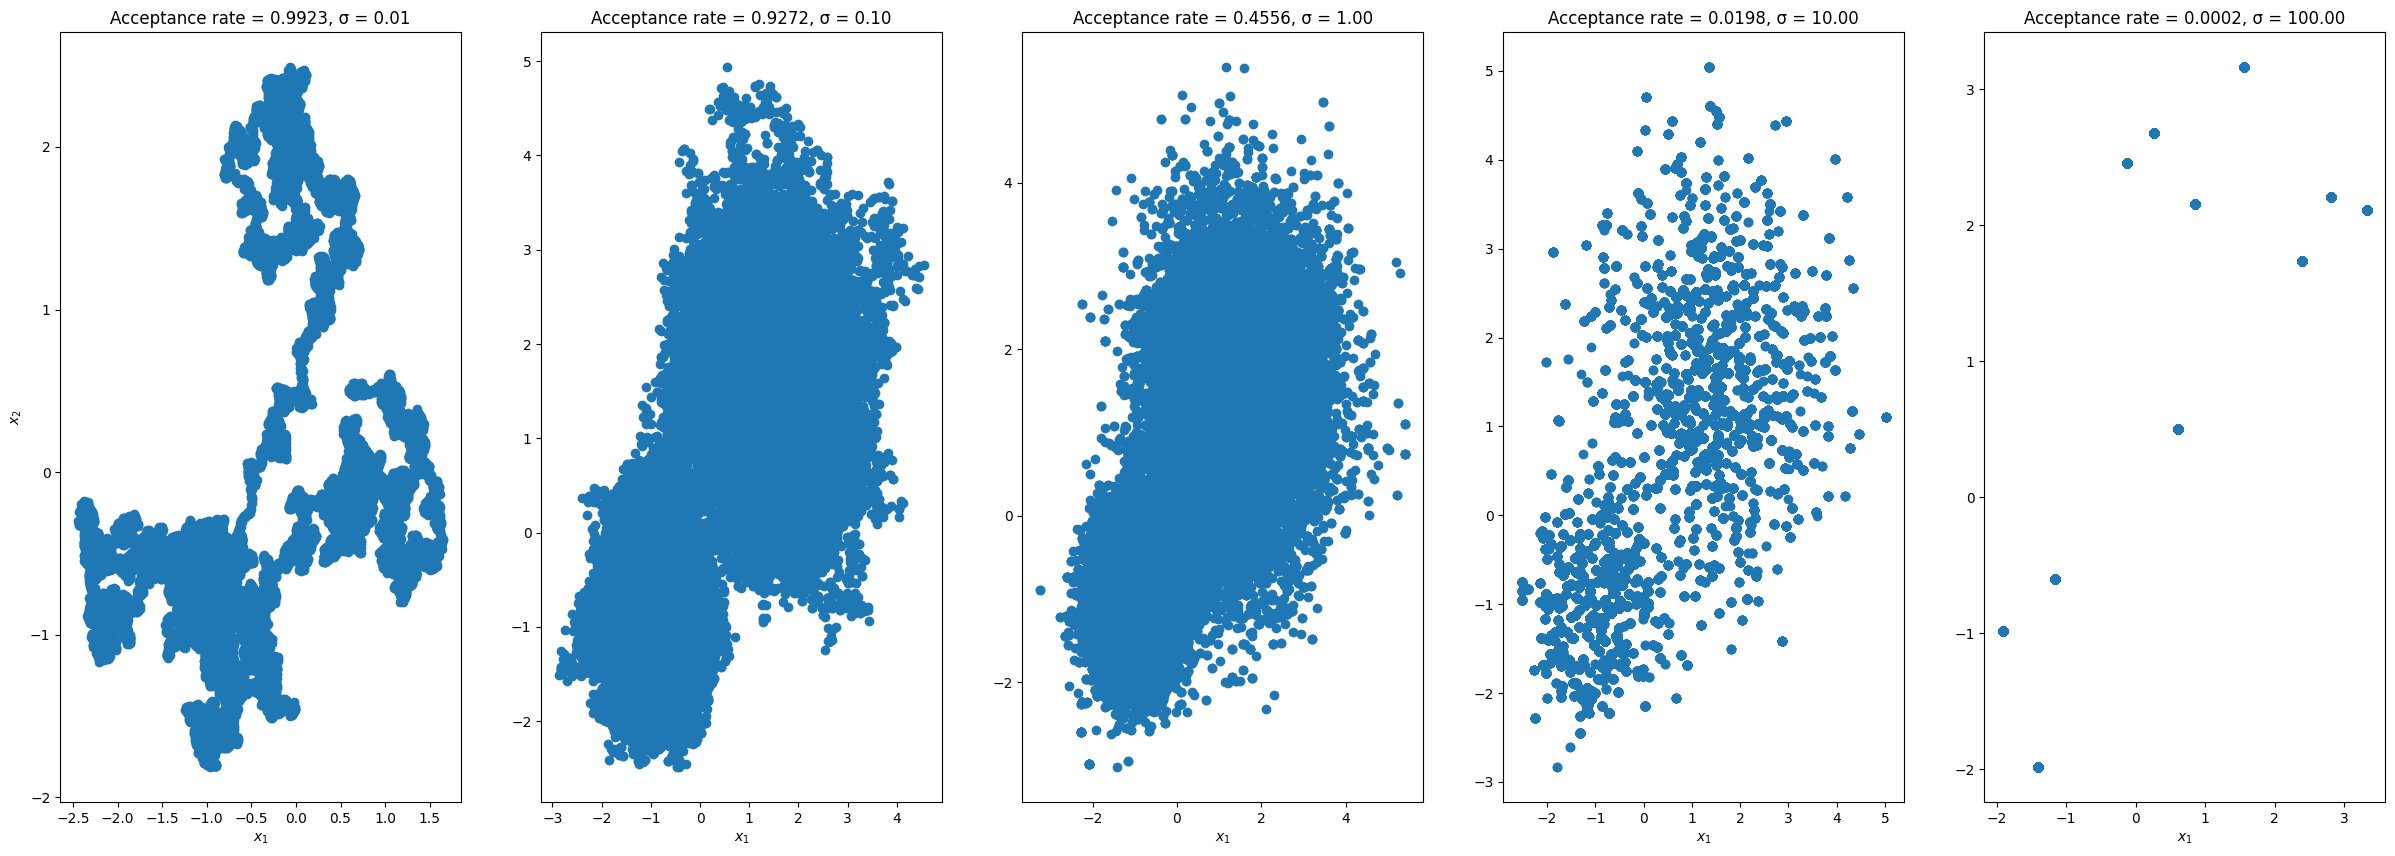

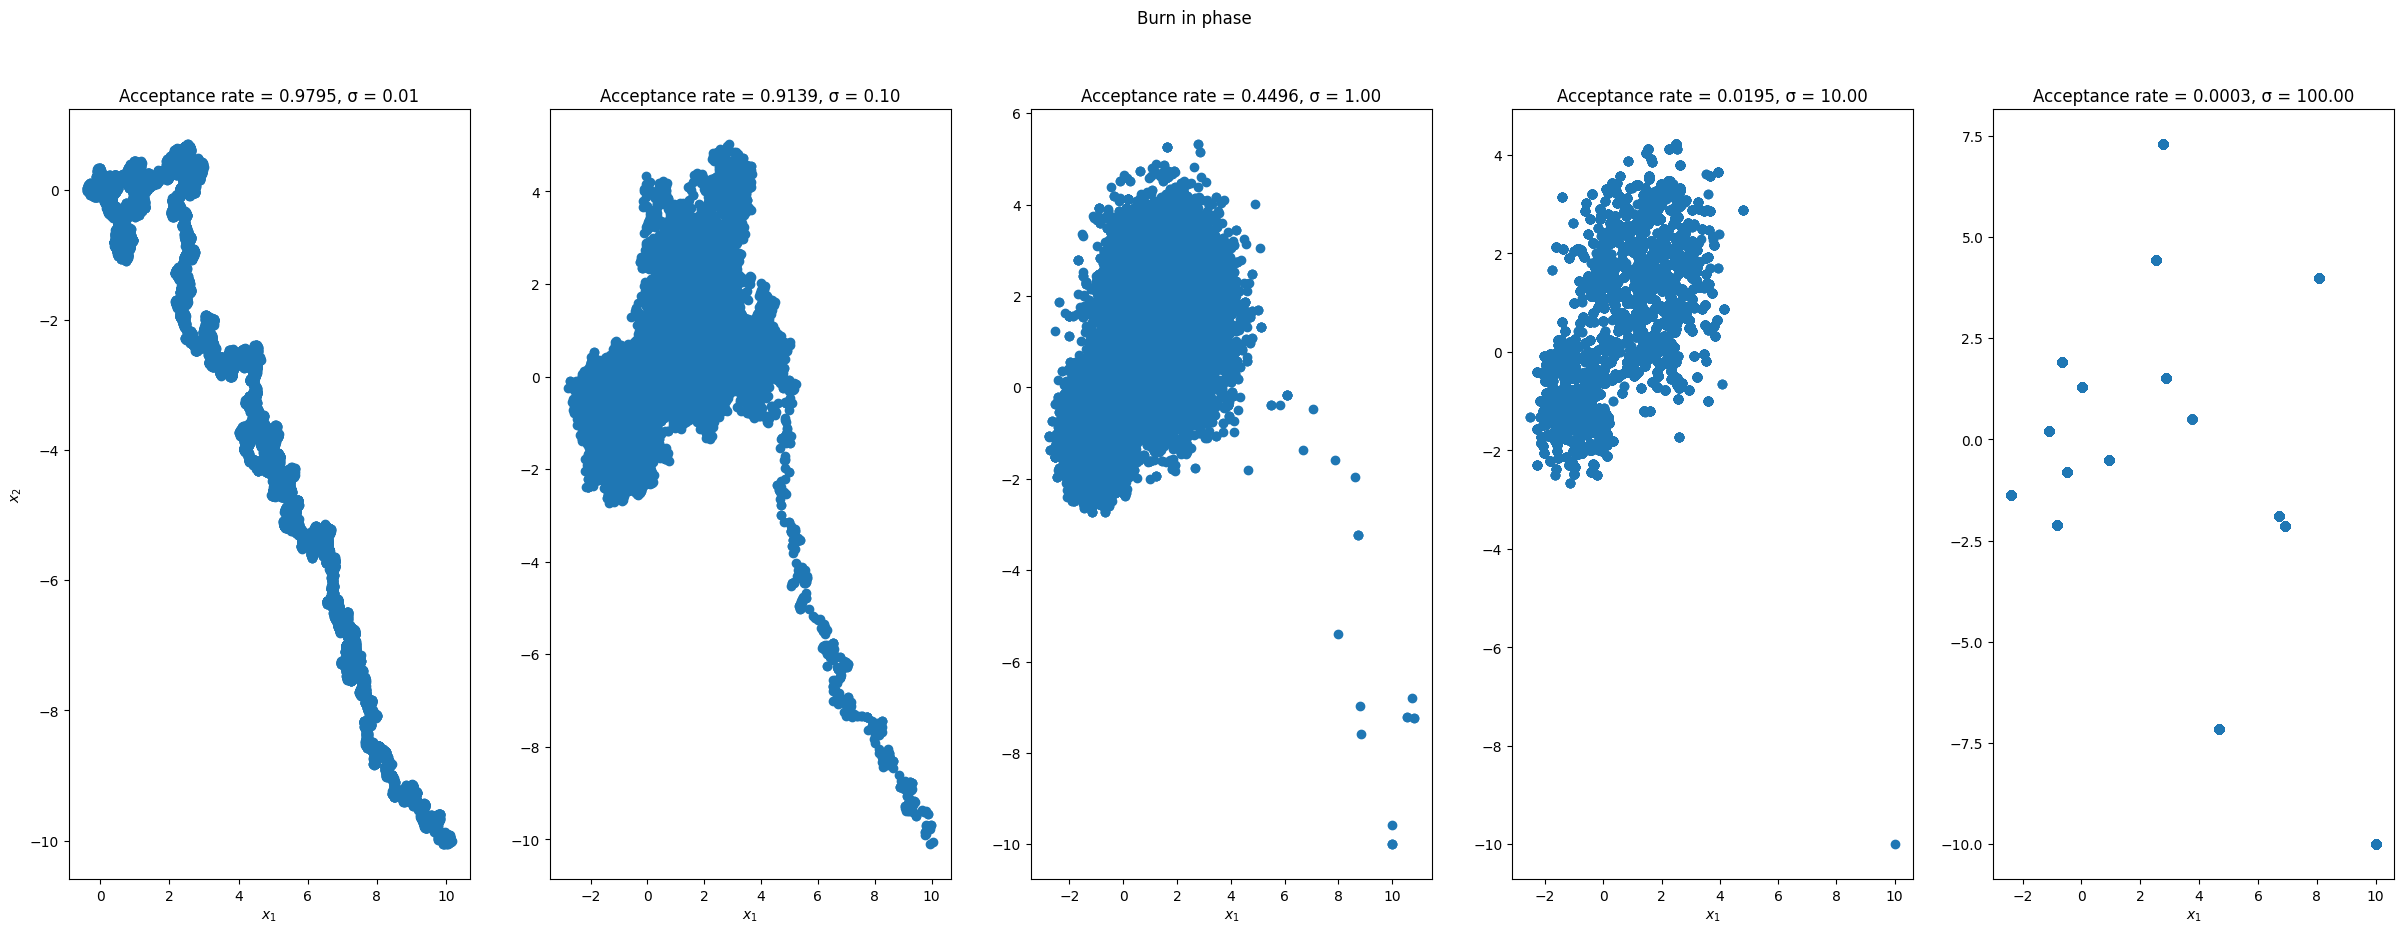

In [8]:
N = 50000
n = 2
sigma =  [0.01,0.1,1,10,100]

x_init = np.array(np.random.rand(n))
fig, ax = plt.subplots(1, 5, figsize=(30,10))
for i, s in enumerate(sigma):
  sampled_values, acceptance_ratio = Metropolis_Hastings(fancy_distribution, N, x_init, s)
  ax[i].scatter(sampled_values[: , 0], sampled_values[: , 1])
  ax[i].set_title('Acceptance rate = {:.4f}, σ = {:.2f}'.format(acceptance_ratio,s))
  if i == 0:
    ax[i].set_ylabel(r'$x_2$')
  ax[i].set_xlabel(r'$x_1$')
plt.show()

x_init = np.array(np.array([10,-10]))
fig, ax = plt.subplots(1,5, figsize=(30,10))
for i,s in enumerate(sigma):
  sampled_values, acceptance_ratio = Metropolis_Hastings(fancy_distribution, N, x_init, s)
  ax[i].scatter(sampled_values[:,0], sampled_values[:,1])
  ax[i].set_title('Acceptance rate = {:.4f}, σ = {:.2f}'.format(acceptance_ratio,s))
  if i ==0:
    ax[i].set_ylabel(r'$x_2$')
  ax[i].set_xlabel(r'$x_1$')
fig.suptitle('Burn in phase')
plt.show()


### Based on the acceptance ratio and visual inspection of the result, the parameter that works best is $\sigma = 1$. We can also verify that by thinking that : An acceptance ratio very close to $1$ means that the model accepts nearly every new 'jump' and we end up actually with a 'random walk'. On the other hand, an acceptance ratio vary close to $0$ means we reject nearly every new 'jump' and we eventually not sampling. Hence, an acceptance ratio of around $0.5$ considering also the visual inspection of the graphs seems to provide the best case of sampling.

###We can clearly see that if it happens to start far away from the optimum the model will 'randomly walk' trying to find the true distribution and sample from it. Hence, the first samples will not actually be sampled from the true distribution. For a very low $\sigma$ the model may not sample from the true distribution in a given number of $N$ and a bigger number of steps must be provided.

###Let's compare our results with the true distribution using 1-dimensional histograms (both in $x_1$ and $x_2$ direction).

<ipython-input-9-38734a7c8ded>:4: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

<ipython-input-9-38734a7c8ded>:5: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



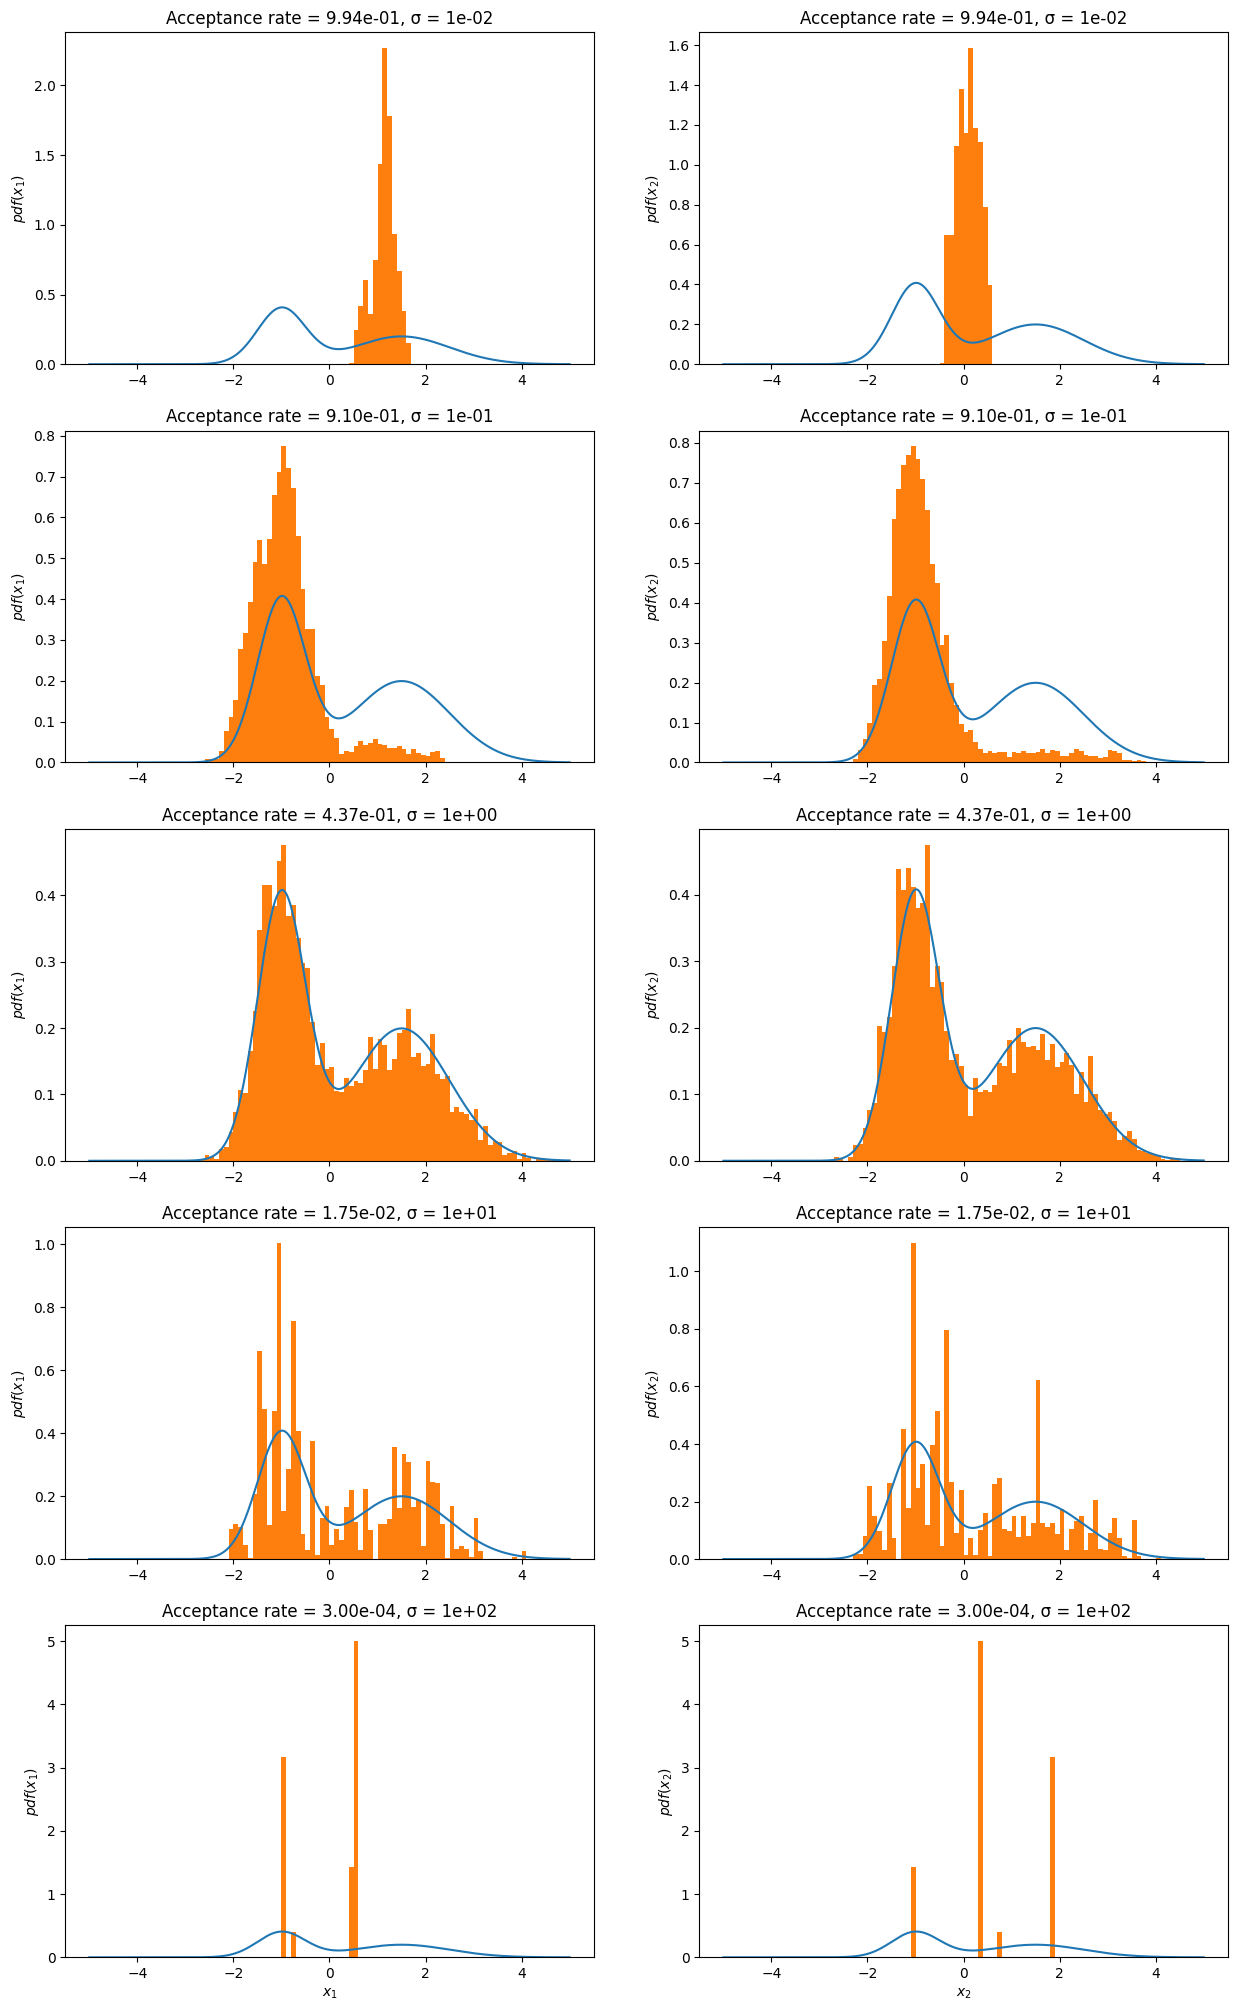

In [9]:
values = np.arange(-5, 5, 8/N)
difference_values = np.diff(values)

fancy_distribution_x1 = np.array([np.sum(fancy_distribution(np.array([i,values]))*difference_values[0]) for i in values])
fancy_distribution_x2 = np.array([np.sum(fancy_distribution(np.array([values,i]))*difference_values[0]) for i in values])

N = 10000
n = 2
sigma =  [0.01,0.1,1,10,100]
x_init = np.array(np.random.rand(n))

fig, ax = plt.subplots(5,2, figsize=(15,25))
for i,s in enumerate(sigma):
  samples, acceptance_ratio = Metropolis_Hastings(fancy_distribution, N, x_init, s)
  ax[i][0].plot(values, fancy_distribution_x1)
  ax[i][0].hist(samples.T[0], bins = 100, range = (-5,5),density = True)
  ax[i][1].plot(values, fancy_distribution_x2)
  ax[i][1].hist(samples.T[1], bins = 100, range = (-5,5), density = True)
  ax[i][0].set_ylabel(r'$pdf(x_1)$')
  ax[i][1].set_ylabel(r'$pdf(x_2)$')
  ax[i][0].set_title('Acceptance rate = {:.2e}, σ = {:.0e}'.format(acceptance_ratio,s))
  ax[i][1].set_title('Acceptance rate = {:.2e}, σ = {:.0e}'.format(acceptance_ratio,s))
  if i ==4:
    ax[i][0].set_xlabel(r'$x_1$')
    ax[i][1].set_xlabel(r'$x_2$')
plt.show()

###The distribution can indeed be recovered for reasonable values of $\sigma$. As we see from the figure above (but also from the scatter plots of the previous question) we can approach the true distribution in case that $\sigma = 1$. For too low or too high values of $\sigma$ we verify the results of the previous question. More specificaly, in the first case even though we accept 'new jumps', we end up with a 'random walk' because we accept nearly all of them, hence we do not approach the true distribution. We can see that, from the hist-columns which do not correspond to the true distribution. On the other hand, in the second case we nearly reject all 'new jumps', thus we do not get new samples and it is clear from the plot where all of the hist-columns actually overlap giving us eventually 2 to 5 columns.

#Simulation

##Animation of the best inference through all accepted & rejected samples in real time

<ipython-input-10-82d89a84ea0b>:5: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning:

invalid value encountered in divide



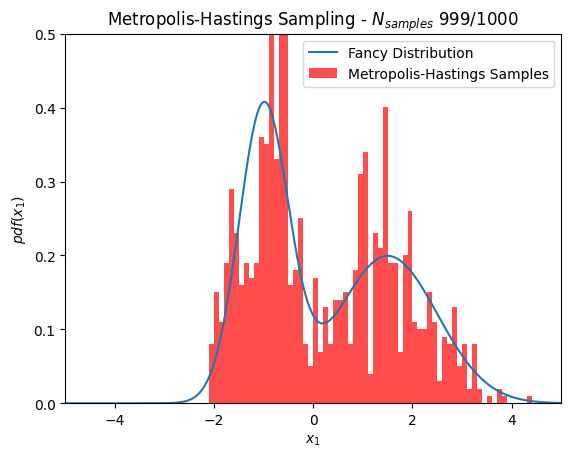

In [10]:
N = 1000
values = np.arange(-5, 5, 8/N)
difference_values = np.diff(values)

fancy_distribution_x1 = np.array([np.sum(fancy_distribution(np.array([i, values])) * difference_values[0]) for i in values])

n = 2
sigma1 = 1
x_init = np.array(np.random.rand(n))

samples, acceptance_ratio = Metropolis_Hastings(fancy_distribution, N, x_init, sigma1)

# Create an animation
def update(frame):
    plt.clf()
    plt.xlim(-5, 5)
    plt.ylim(0, 0.409)
    plt.title(f'Metropolis-Hastings Sampling - $N_{{\t{{samples}}}}$ {frame}/{N}')

    # Plot the true distribution
    plt.plot(values, fancy_distribution_x1, label='Fancy Distribution')

    # Plot the generated samples histogram
    plt.hist(samples[:frame, 0], bins=100, range=(-5, 5), density=True, alpha=0.7, color='red', label='Metropolis-Hastings Samples')

    # Add labels and legend
    plt.ylabel(r'$pdf(x_1)$')
    plt.xlabel(r'$x_1$')
    plt.legend()

# Set up the figure
fig = plt.figure()

# Create the animation
ani = FuncAnimation(fig, update, frames=N, interval=175, repeat=False)

# Save the animation as a GIF
ani.save('./Metropolis_Hastings.gif', writer='imagemagick')

# Display the animation
plt.show()


##Animation while displaying in real time how the normal distribution rejects and accepts samples from the fancy distribution (which might be useful to if we may want to improve the inference)

<ipython-input-11-a5a48ee98754>:5: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning:

invalid value encountered in divide



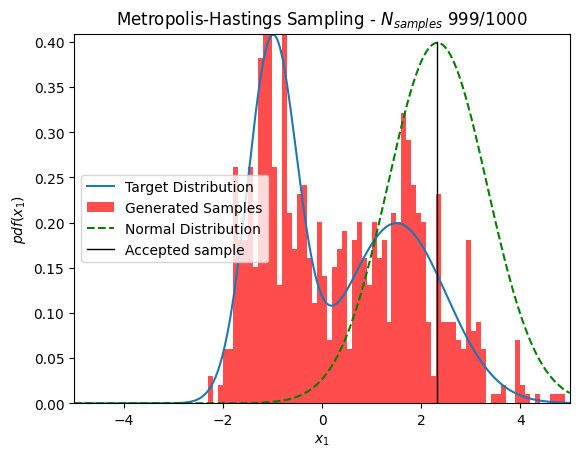

In [11]:
N = 1000
values = np.arange(-5, 5, 8/N)
difference_values = np.diff(values)

fancy_distribution_x1 = np.array([np.sum(fancy_distribution(np.array([i, values])) * difference_values[0]) for i in values])

n = 2
sigma1 = 1
x_init = np.array(np.random.rand(n))

samples, acceptance_ratio = Metropolis_Hastings(fancy_distribution, N, x_init, sigma1)

def distribution_normale(x, mean, std_deviation):
    return (1 / (std_deviation * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_deviation)**2)



def update(frame):
    plt.clf()
    plt.xlim(-5, 5)                                                            # Animation
    plt.ylim(0, 0.409)
    plt.title(f'Metropolis-Hastings Sampling - $N_{{\t{{samples}}}}$ {frame}/{N}')

    # Plot the true distribution
    plt.plot(values, fancy_distribution_x1, label='Target Distribution')

    # Plot the generated samples histogram
    plt.hist(samples[:frame, 0], bins=100, range=(-5, 5), density=True, alpha=0.7, color='red', label='Generated Samples')

    # Plot the Normal Distribution (Green curve)
    prop_dist, = plt.plot(values, distribution_normale(values, samples[frame, 0], sigma1), 'g--', label='Normal Distribution')


    # Plot the proposed state that was accepted (Black vertical line)
    accepted_line, = plt.plot([samples[frame, 0], samples[frame, 0]], [0, 0.40], 'k-', linewidth=1, label='Accepted sample')


    # Add labels and legend
    plt.ylabel(r'$pdf(x_1)$')
    plt.xlabel(r'$x_1$')
    plt.legend()

# Set up the figure
fig = plt.figure()

# Create the animation with a time delay of 200 milliseconds between frames
ani = FuncAnimation(fig, update, frames=N, interval=175, repeat=False)

# Save the animation as a GIF
ani.save('./Metropolis_Hastings_Normal_sampling.gif', writer='imagemagick')

# Display the animation
plt.show()
